In [1]:
import pandas as pd
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using Theano backend.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [3]:
import quantecon

In [72]:
from yahoo_finance import Share

In [73]:
apl = Share('AAPL')

In [79]:
apl_hist = apl.get_historical('2016-10-01', '2016-12-01')

In [83]:
apl_open = []
for a in apl_hist:
    apl_open.append(a['Open'])
    

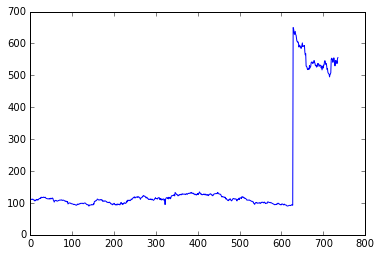

In [91]:
plt.plot(apl_open)

In [85]:
dataframe = pd.DataFrame({'open':apl_open})

In [89]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)

Epoch 1/100
13s - loss: 3.1782e-04
Epoch 2/100
13s - loss: 8.6305e-05
Epoch 3/100
13s - loss: 2.2864e-05
Epoch 4/100
13s - loss: 2.1440e-05
Epoch 5/100
13s - loss: 2.1978e-05
Epoch 6/100
12s - loss: 2.0264e-05
Epoch 7/100
13s - loss: 2.1720e-05
Epoch 8/100
13s - loss: 2.4399e-05
Epoch 9/100
13s - loss: 2.1714e-05
Epoch 10/100
13s - loss: 2.1455e-05
Epoch 11/100
13s - loss: 2.1552e-05
Epoch 12/100
13s - loss: 2.3914e-05
Epoch 13/100
12s - loss: 2.2903e-05
Epoch 14/100
13s - loss: 2.0243e-05
Epoch 15/100
13s - loss: 2.2079e-05
Epoch 16/100
13s - loss: 2.1436e-05
Epoch 17/100
12s - loss: 2.1369e-05
Epoch 18/100
12s - loss: 2.0203e-05
Epoch 19/100
13s - loss: 2.1527e-05
Epoch 20/100
13s - loss: 2.0615e-05
Epoch 21/100
13s - loss: 2.2126e-05
Epoch 22/100
13s - loss: 2.0959e-05
Epoch 23/100
13s - loss: 2.1396e-05
Epoch 24/100
13s - loss: 1.9207e-05
Epoch 25/100
13s - loss: 2.0356e-05
Epoch 26/100
13s - loss: 1.9378e-05
Epoch 27/100
13s - loss: 1.8315e-05
Epoch 28/100
13s - loss: 1.8532e-05
E

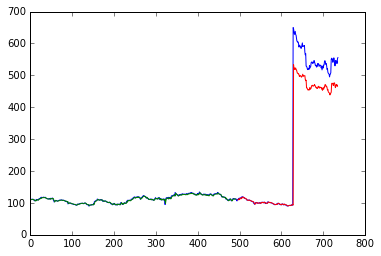

In [90]:
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()